In [1]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession

#connect to Spark
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("KMeans")\
        .config("spark.sql.broadcastTimeout", "36000")\
        .config("spark.memory.fraction", 0.8) \
        .config("spark.executor.memory", "16g") \
        .config("spark.driver.memory", "16g")\
        .config("spark.sql.shuffle.partitions" , "800") \
        .config("spark.memory.offHeap.enabled",'true')\
        .config("spark.memory.offHeap.size","16g")\
        .getOrCreate()


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

#read ratings.csv
schema_rating = (StructType().add("userId",IntegerType()).add("movieId",IntegerType()).add("rating",FloatType()).add("timestamp",StringType()))
ratingsdf = spark.read.csv("ratings.csv", schema = schema_rating, header = True)

In [3]:
ratingsdf = ratingsdf.dropna()

In [4]:
#read movie.csv
schema = (StructType().add("movieId",IntegerType()).add("title",StringType()).add("genres",StringType()))
moviesdf = spark.read.csv("movies.csv", schema = schema, header = True)
#clean movie data
moviesdf = moviesdf.filter(moviesdf.genres != "(s listed)")
moviesdf = moviesdf.filter(moviesdf.genres != "(no genres listed)")
moviesdf = moviesdf.dropna()

#add year column to movie
moviesdf = moviesdf.withColumn('year',
                        regexp_extract(moviesdf['title'], '[1-2][0-9][0-9][0-9]', 0).cast(IntegerType()))

#generate dataframe of movie and rating           
df_for_k_means = moviesdf.join(ratingsdf, moviesdf.movieId == ratingsdf.movieId).drop(ratingsdf.movieId).drop(ratingsdf.timestamp).drop(moviesdf.title)
df_for_k_means.show()



+-------+--------------------+----+------+------+
|movieId|              genres|year|userId|rating|
+-------+--------------------+----+------+------+
|      1|Adventure|Animati...|1995|     1|   4.0|
|      3|      Comedy|Romance|1995|     1|   4.0|
|      6|Action|Crime|Thri...|1995|     1|   4.0|
|     47|    Mystery|Thriller|1995|     1|   5.0|
|     50|Crime|Mystery|Thr...|1995|     1|   5.0|
|     70|Action|Comedy|Hor...|1996|     1|   3.0|
|    101|Adventure|Comedy|...|1996|     1|   5.0|
|    110|    Action|Drama|War|1995|     1|   4.0|
|    151|Action|Drama|Roma...|1995|     1|   5.0|
|    157|          Comedy|War|1995|     1|   5.0|
|    163|Action|Romance|We...|1995|     1|   5.0|
|    216|              Comedy|1995|     1|   5.0|
|    223|              Comedy|1994|     1|   3.0|
|    231|    Adventure|Comedy|1994|     1|   5.0|
|    235|        Comedy|Drama|1994|     1|   4.0|
|    260|Action|Adventure|...|1977|     1|   5.0|
|    296|Comedy|Crime|Dram...|1994|     1|   3.0|


In [5]:
#get dummy variables of genres
from pyspark.sql.functions import split, array_contains
category = ['Adventure',
          'Animation',
          'Children',
         'Comedy',
         'Fantasy',
         'Romance',
         'Action',
         'Crime',
         'Thriller',
         'Mystery',
         'Horror',
         'Drama',
         'War',
         'Western',
         'Sci-Fi',
         'Musical',
         'Film-Noir',
         'IMAX',
         'Documentary']
genre_cols = df_for_k_means.withColumn('genre', split('genres', '\|')) \
  .select('movieId', *[ array_contains('genre', c).astype('int').alias(c) for c in category ])
genre_cols.show(30, truncate=False)


+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|movieId|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|1      |1        |1        |1       |1     |1      |0      |0     |0    |0       |0      |0     |0    |0  |0      |0     |0      |0        |0   |0          |
|3      |0        |0        |0       |1     |0      |1      |0     |0    |0       |0      |0     |0    |0  |0      |0     |0      |0        |0   |0          |
|6      |0        |0        |0       |0     |0      |0      |1     |1    |1       |0      |0     |0    |0  |0      |0     |0      |0        |0   |0          |
|47     |0        |0        |0       |0     |0

In [6]:
#genereate original feature dataframe, now it has movieId and userId
df_for_k_means = df_for_k_means.dropna()
features = df_for_k_means.join(genre_cols, df_for_k_means.movieId == genre_cols.movieId, "inner").drop(genre_cols.movieId).distinct()
features = features.drop('genres')
features.show()

+----+------+------+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|year|userId|rating|movieId|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+----+------+------+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|1997|     1|   3.0|   1580|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|     0|    0|  0|      0|     1|      0|        0|   0|          0|
|1997|     4|   3.0|   1580|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|     0|    0|  0|      0|     1|      0|        0|   0|          0|
|1997|    18|   3.5|   1580|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|

In [7]:
#just to check whether the dummy variables are correct or not
features.sort("movieId").show(truncate=False)

+----+------+------+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|year|userId|rating|movieId|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+----+------+------+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|1995|57    |5.0   |1      |1        |1        |1       |1     |1      |0      |0     |0    |0       |0      |0     |0    |0  |0      |0     |0      |0        |0   |0          |
|1995|33    |3.0   |1      |1        |1        |1       |1     |1      |0      |0     |0    |0       |0      |0     |0    |0  |0      |0     |0      |0        |0   |0          |
|1995|54    |3.0   |1      |1        |1        |1       |1     |1      |0      |0     |0    |0       |0      |

In [7]:
#features with userId to be used as identity now 
features = features.drop('movieId') 
features = features.select('userId', 'year','rating','Adventure',
          'Animation',
          'Children',
         'Comedy',
         'Fantasy',
         'Romance',
         'Action',
         'Crime',
         'Thriller',
         'Mystery',
         'Horror',
         'Drama',
         'War',
         'Western',
         'Sci-Fi',
         'Musical',
         'Film-Noir',
         'IMAX',
         'Documentary')
features.show()

+------+----+------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|userId|year|rating|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+------+----+------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|     1|1997|   3.0|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|     0|    0|  0|      0|     1|      0|        0|   0|          0|
|     4|1997|   3.0|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|     0|    0|  0|      0|     1|      0|        0|   0|          0|
|    18|1997|   3.5|        0|        0|       0|     1|      0|      0|     1|    0|       0|      0|     0|    0|  0|      0|     1|      0|        

In [9]:
#check datatype
features.schema

StructType(List(StructField(userId,IntegerType,true),StructField(year,IntegerType,true),StructField(rating,FloatType,true),StructField(Adventure,IntegerType,true),StructField(Animation,IntegerType,true),StructField(Children,IntegerType,true),StructField(Comedy,IntegerType,true),StructField(Fantasy,IntegerType,true),StructField(Romance,IntegerType,true),StructField(Action,IntegerType,true),StructField(Crime,IntegerType,true),StructField(Thriller,IntegerType,true),StructField(Mystery,IntegerType,true),StructField(Horror,IntegerType,true),StructField(Drama,IntegerType,true),StructField(War,IntegerType,true),StructField(Western,IntegerType,true),StructField(Sci-Fi,IntegerType,true),StructField(Musical,IntegerType,true),StructField(Film-Noir,IntegerType,true),StructField(IMAX,IntegerType,true),StructField(Documentary,IntegerType,true)))

In [8]:
#convert all the columns in features dataframe into Float type except userId
FEATURES_COL = ['year','rating','Adventure',
          'Animation',
          'Children',
         'Comedy',
         'Fantasy',
         'Romance',
         'Action',
         'Crime',
         'Thriller',
         'Mystery',
         'Horror',
         'Drama',
         'War',
         'Western',
         'Sci-Fi',
         'Musical',
         'Film-Noir',
         'IMAX',
         'Documentary']
features_float = features
for col in features_float.columns:
    if col in FEATURES_COL:
        features_float = features_float.withColumn(col,features_float[col].cast('float'))
features_float.show()

+------+------+------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|userId|  year|rating|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+------+------+------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|     1|1997.0|   3.0|      0.0|      0.0|     0.0|   1.0|    0.0|    0.0|   1.0|  0.0|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   1.0|    0.0|      0.0| 0.0|        0.0|
|     4|1997.0|   3.0|      0.0|      0.0|     0.0|   1.0|    0.0|    0.0|   1.0|  0.0|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   1.0|    0.0|      0.0| 0.0|        0.0|
|    18|1997.0|   3.5|      0.0|      0.0|     0.0|   1.0|    0.0|    0.0|   1.0|  0.0|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   1.0|    

In [11]:
#check type conversion results

features_float.schema

StructType(List(StructField(userId,IntegerType,true),StructField(year,FloatType,true),StructField(rating,FloatType,true),StructField(Adventure,FloatType,true),StructField(Animation,FloatType,true),StructField(Children,FloatType,true),StructField(Comedy,FloatType,true),StructField(Fantasy,FloatType,true),StructField(Romance,FloatType,true),StructField(Action,FloatType,true),StructField(Crime,FloatType,true),StructField(Thriller,FloatType,true),StructField(Mystery,FloatType,true),StructField(Horror,FloatType,true),StructField(Drama,FloatType,true),StructField(War,FloatType,true),StructField(Western,FloatType,true),StructField(Sci-Fi,FloatType,true),StructField(Musical,FloatType,true),StructField(Film-Noir,FloatType,true),StructField(IMAX,FloatType,true),StructField(Documentary,FloatType,true)))

In [9]:
#scale data using MinMaxScaler

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

testdf = features_float

assemblers = [VectorAssembler(inputCols= [col], outputCol=col + "_vec") for col in FEATURES_COL]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in FEATURES_COL]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(testdf)
scaledData = scalerModel.transform(testdf)
scaledData.show()

+------+------+------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+--------+----------+-------------+-------------+------------+----------+-----------+-----------+----------+---------+------------+-----------+----------+---------+-------+-----------+----------+-----------+-------------+--------+---------------+--------------------+--------------------+----------------+----------------+---------------+-------------+--------------+--------------+-------------+------------+---------------+--------------+-------------+------------+----------+--------------+-------------+--------------+----------------+-----------+------------------+
|userId|  year|rating|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|year_vec|rating_vec|Adventure_vec|Animation_vec|Children_vec|Comedy_vec|Fantasy_vec|Roma

In [10]:
#generate new scaled dataframe with scaled features

from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id as mi

scaledData2 = scaledData

names = {x + "_scaled": x for x in FEATURES_COL}
data1 = scaledData.select([F.col(c).alias(names[c]) for c in names.keys()])  #add userId
data2 = scaledData.select('userId')

id=mi()
data1 = data1.withColumn("match_id", id)
data2 = data2.withColumn("match_id", id)
data2 = data2.join(data1,data1.match_id==data2.match_id, 'inner').drop(data1.match_id)
data2 = data2.drop(data2.match_id)
scaledData = data2
scaledData.show()

+------+--------------------+--------------------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+-----+-------+------+-------+---------+-----+-----------+
|userId|                year|              rating|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|  War|Western|Sci-Fi|Musical|Film-Noir| IMAX|Documentary|
+------+--------------------+--------------------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+-----+-------+------+-------+---------+-----+-----------+
|    64|[0.9418493803622497]|[0.7777777777777777]|    [0.0]|    [0.0]|   [0.0]| [1.0]|  [1.0]|  [1.0]| [0.0]|[0.0]|   [0.0]|  [0.0]| [0.0]|[1.0]|[0.0]|  [0.0]| [0.0]|  [0.0]|    [0.0]|[0.0]|      [0.0]|
|   609|[0.9494756911344137]|[0.7777777777777777]|    [0.0]|    [0.0]|   [0.0]| [0.0]|  [0.0]|  [0.0]| [0.0]|[1.0]|   [1.0]|  [0.0]| [0.0]|[0.0]|[0.0]|  [0.0]| [0.0]|  [0.0]|    [0.0]|[0.0

In [11]:
#Convert the features data to dense vector

from __future__ import print_function
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark.ml.clustering import KMeans
%matplotlib inline


scaledData = scaledData.dropna()

vecAssembler = VectorAssembler(inputCols= FEATURES_COL, outputCol="features", handleInvalid="skip")
df_kmeans = vecAssembler.transform(scaledData).select('userId','features')

df_kmeans.show()

+------+--------------------+
|userId|            features|
+------+--------------------+
|    64|(21,[0,1,5,6,7,13...|
|   609|(21,[0,1,9,10],[0...|
|   469|(21,[0,1,4,5],[0....|
|   105|(21,[0,1,5,13],[0...|
|    45|(21,[0,1,5],[0.94...|
|   462|(21,[0,1,13],[0.9...|
|    19|(21,[0,1,5],[0.93...|
|   288|(21,[0,1,2,4,5,6]...|
|   430|(21,[0,1,2,3,4,5,...|
|   105|(21,[0,1,13],[0.9...|
|   122|(21,[0,1,10,12,13...|
|     1|(21,[0,1,5,13],[0...|
|   101|(21,[0,1,2,8,16],...|
|   294|(21,[0,1,2,5,8],[...|
|   139|(21,[0,1,2,3,4,5,...|
|   554|(21,[0,1,13],[0.9...|
|    68|(21,[0,1,13,14],[...|
|   232|(21,[0,1,5],[0.95...|
|   105|(21,[0,1,3,5],[0....|
|   380|(21,[0,1,2,6,8,13...|
+------+--------------------+
only showing top 20 rows



In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 19 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=19).fit(df_kmeans)

df_kmeans = featureIndexer.transform(df_kmeans)
df_kmeans.show()
df_kmeans.cache()

+------+--------------------+--------------------+
|userId|            features|     indexedFeatures|
+------+--------------------+--------------------+
|    64|(21,[0,1,5,6,7,13...|(21,[0,1,5,6,7,13...|
|   609|(21,[0,1,9,10],[0...|(21,[0,1,9,10],[0...|
|   469|(21,[0,1,4,5],[0....|(21,[0,1,4,5],[0....|
|   105|(21,[0,1,5,13],[0...|(21,[0,1,5,13],[0...|
|    45|(21,[0,1,5],[0.94...|(21,[0,1,5],[0.94...|
|   462|(21,[0,1,13],[0.9...|(21,[0,1,13],[0.9...|
|    19|(21,[0,1,5],[0.93...|(21,[0,1,5],[0.93...|
|   288|(21,[0,1,2,4,5,6]...|(21,[0,1,2,4,5,6]...|
|   430|(21,[0,1,2,3,4,5,...|(21,[0,1,2,3,4,5,...|
|   105|(21,[0,1,13],[0.9...|(21,[0,1,13],[0.9...|
|   122|(21,[0,1,10,12,13...|(21,[0,1,10,12,13...|
|     1|(21,[0,1,5,13],[0...|(21,[0,1,5,13],[0...|
|   101|(21,[0,1,2,8,16],...|(21,[0,1,2,8,16],...|
|   294|(21,[0,1,2,5,8],[...|(21,[0,1,2,5,8],[...|
|   139|(21,[0,1,2,3,4,5,...|(21,[0,1,2,3,4,5,...|
|   554|(21,[0,1,13],[0.9...|(21,[0,1,13],[0.9...|
|    68|(21,[0,1,13,14],[...|(2

DataFrame[userId: int, features: vector, indexedFeatures: vector]

In [16]:
# Determine optimal number of clusters by using Silhoutte Score Analysis.

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='indexedFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,20):    
    KMeans_algo=KMeans(featuresCol='indexedFeatures', k=i)  
    KMeans_fit=KMeans_algo.fit(df_kmeans)  
    output=KMeans_fit.transform(df_kmeans)    
    score=evaluator.evaluate(output)   
    silhouette_score.append(score)   
    print("Silhouette Score:",score)

Silhouette Score: 0.604144052191206
Silhouette Score: 0.4820606844424913
Silhouette Score: 0.3530194428139273
Silhouette Score: 0.33424819624148133
Silhouette Score: 0.31099387002218165
Silhouette Score: 0.2810611392598347
Silhouette Score: 0.271565408685879
Silhouette Score: 0.2641341809021929
Silhouette Score: 0.25929065988908917
Silhouette Score: 0.23924036973861235
Silhouette Score: 0.26961630897963224
Silhouette Score: 0.2511010290881076
Silhouette Score: 0.23521951312096878
Silhouette Score: 0.221227984248844
Silhouette Score: 0.2466587925220509
Silhouette Score: 0.2342174764253521
Silhouette Score: 0.2417341250957925
Silhouette Score: 0.22677714023529544


Text(0, 0.5, 'Silhouette Scores')

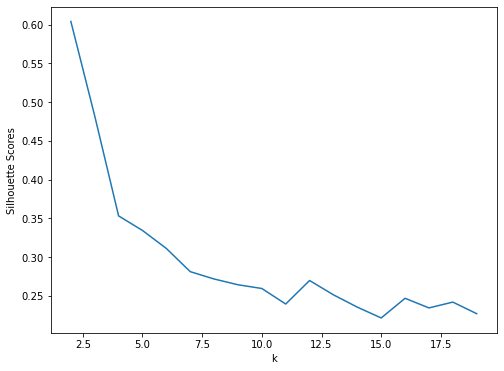

In [17]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Scores')

In [13]:
#Train the machine learning model
k = 11
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("indexedFeatures")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[9.49735253e-01 6.00000000e+00 1.37369915e-01 4.88174078e-02
 5.71428571e-02 8.61684011e-01 1.27909177e-01 2.73036897e-01
 1.89782403e-01 1.09933775e-01 4.76821192e-02 2.38410596e-02
 6.58467360e-02 2.29328288e-01 2.30842006e-02 1.74077578e-02
 8.51466414e-02 4.56007569e-02 2.83822138e-03 1.77861873e-02
 4.06811731e-02]
[0.94927442 2.80824411 0.23383298 0.04732334 0.09443255 0.46038544
 0.11852248 0.16948608 0.33458244 0.12698073 0.26220557 0.05910064
 0.10974304 0.30235546 0.02687366 0.01638116 0.19336188 0.03265525
 0.00396146 0.02890792 0.00374732]
[9.49654111e-01 6.92847682e+00 4.83443709e-01 1.35506877e-02
 2.03769740e-03 3.11767702e-02 5.69536424e-02 3.97350993e-02
 8.19154356e-01 1.89811513e-01 6.44829343e-01 1.38869078e-01
 1.14620479e-01 6.31686195e-02 1.65053490e-02 1.66072338e-02
 5.25114620e-01 0.00000000e+00 1.69128884e-02 1.22567499e-01
 1.01884870e-04]
[9.46854411e-01 7.27194386e+00 1.20029546e-01 2.33903730e-02
 1.93278345e-02 9.07792687e-01 7.62033731

In [14]:
#Assign clusters to users
transformed = model.transform(df_kmeans).select('userId', 'prediction')
rows = transformed.collect()


In [15]:
#create a new dataframe using SQL context and see the results
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
df_pred = sqlContext.createDataFrame(rows)

#output the prediction results, useid and cluster number
df_pred.show()

+------+----------+
|userId|prediction|
+------+----------+
|    64|         7|
|   609|         2|
|   469|         9|
|   105|         7|
|    45|        10|
|   462|         7|
|    19|         1|
|   288|        10|
|   430|        10|
|   105|         7|
|   122|         9|
|     1|        10|
|   101|         2|
|   294|         4|
|   139|         1|
|   554|        10|
|    68|        10|
|   232|        10|
|   105|         9|
|   380|         9|
+------+----------+
only showing top 20 rows



In [16]:
#Write the prediction output to a csv file to check result
df_pred.toPandas().to_csv('prediction.csv')

In [18]:
df_pred.schema

StructType(List(StructField(userId,LongType,true),StructField(prediction,LongType,true),StructField(year,VectorUDT,true),StructField(rating,VectorUDT,true),StructField(Adventure,VectorUDT,true),StructField(Animation,VectorUDT,true),StructField(Children,VectorUDT,true),StructField(Comedy,VectorUDT,true),StructField(Fantasy,VectorUDT,true),StructField(Romance,VectorUDT,true),StructField(Action,VectorUDT,true),StructField(Crime,VectorUDT,true),StructField(Thriller,VectorUDT,true),StructField(Mystery,VectorUDT,true),StructField(Horror,VectorUDT,true),StructField(Drama,VectorUDT,true),StructField(War,VectorUDT,true),StructField(Western,VectorUDT,true),StructField(Sci-Fi,VectorUDT,true),StructField(Musical,VectorUDT,true),StructField(Film-Noir,VectorUDT,true),StructField(IMAX,VectorUDT,true),StructField(Documentary,VectorUDT,true)))

In [21]:
df_pred.cache()

DataFrame[userId: bigint, prediction: bigint]

In [22]:
#dataframe with movieId, raings, title, genres, userId
movie_title = moviesdf.join(ratingsdf, moviesdf.movieId == ratingsdf.movieId,how='inner').drop(ratingsdf.movieId).drop(ratingsdf.timestamp).cache()

In [23]:
#get the prediction clusters when you input a userId
#prediction = 57 when user id is 10: user with id 57 is clustered into number 10 cluster 
#output: cluster number
def get_prediction(uid): 
    uid_df = df_pred.filter(df_pred.userId == uid)
    pandasdf = uid_df.toPandas()
    #change prediction into long type
    list_pre = pandasdf[-1:]['prediction'].tolist()
    prediction = list_pre[0]
    print(prediction)
    return prediction





In [24]:

get_prediction(57)

10


10

In [27]:
#define movie_recommendation function: You input the user id to run the function then it will give you two tables. 
#First table is the top 5 most watched  movies of your clusters' users. Second one is the top 5 most rating movies of your clusters' users.

#uid: user id 

def movie_recommendation(uid): 
    #find the clusters of this user
    prediction = get_prediction(uid)
    
    recon_df =  df_pred.filter(df_pred.prediction == prediction)
    #get other users' ids in same cluster
    recon_df = recon_df.select('userId')
    recon_df = recon_df.filter(recon_df.userId != uid)
    #get other users' watched movie infomation
    recon_df = recon_df.join(movie_title, recon_df.userId == movie_title.userId,how='inner').drop(movie_title.userId)
    #count watched time of each movie
    rating_number = recon_df.groupBy(recon_df.movieId).count()
    
    #select top5 watched time movies'ids
    most_watched_id = rating_number.orderBy(desc("count")).limit(5)
    #according movie ids generate specific movie information
    most_watched = movie_title.join(most_watched_id, most_watched_id.movieId == movie_title.movieId,how='inner').drop(most_watched_id.movieId).drop(movie_title.userId).drop(movie_title.rating).distinct()
    most_watched.show() #show the first table 
    
    #count average movie ratings of other users' watched movie
    highest_rating = recon_df.groupBy(recon_df.movieId).agg(avg("rating").alias("avg_rating"))
    #select top5 rating movies'ids
    highest_rating = highest_rating.orderBy(desc("avg_rating")).limit(5)
    #according movie ids generate specific movie information
    highest_rating = movie_title.join(highest_rating, highest_rating.movieId == movie_title.movieId,how='inner').drop(highest_rating.movieId).drop(movie_title.userId).drop(movie_title.rating).distinct()
    highest_rating.show() #show the second table 

In [28]:
#call the movie_recommendation
#here you can change the number"57" into other userId to see the movie recommendations of specific user

#First table is the top 5 most watched  movies of your clusters' users. Second one is the top 5 most rating movies of your clusters' users.
movie_recommendation(57)

10
+--------------------+--------------------+----+-------+-----+
|               title|              genres|year|movieId|count|
+--------------------+--------------------+----+-------+-----+
|  Matrix, The (1999)|Action|Sci-Fi|Thr...|1999|   2571| 9807|
|Jurassic Park (1993)|Action|Adventure|...|1993|    480| 9871|
| Pulp Fiction (1994)|Comedy|Crime|Dram...|1994|    296|10614|
|Star Wars: Episod...|Action|Adventure|...|1977|    260|10016|
| Forrest Gump (1994)|Comedy|Drama|Roma...|1994|    356|11397|
+--------------------+--------------------+----+-------+-----+

+--------------------+--------------------+----+-------+----------+
|               title|              genres|year|movieId|avg_rating|
+--------------------+--------------------+----+-------+----------+
|Investigation Hel...|           Animation|1986| 172583|       5.0|
|Tenchi Muyô! In L...|    Animation|Comedy|1996| 157775|       5.0|
|Strictly Sexual (...|Comedy|Drama|Romance|2008|  67618|       5.0|
|Scooby-Doo! Abrac...